In [198]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import csv
import random
import glob
from tqdm.auto import tqdm
from PIL import Image
from skimage.color import rgb2hsv

In [199]:
def resize_image(image, output_height, output_width):
    input_height, input_width, channels = image.shape
    output = np.zeros(
        (output_height, output_width, channels), dtype=image.dtype
    )

    for i in range(output_height):
        for j in range(output_width):
            input_i = int(i / output_height * input_height)
            input_j = int(j / output_width * input_width)
            output[i, j] = image[input_i, input_j]

    return output

In [245]:
from enum import Enum


class Labels(Enum):
    CLEAR = 0
    WATER = 1
    CLOUDS = 2


def load_dataset():
    # Load labels
    labels = []
    with open("data/labels.csv") as file:
        for i, row in enumerate(csv.reader(file)):
            tags = row[1]
            # if "water" in tags:
            #     labels.append(Labels.WATER)
            if "clear" in tags or "haze" in tags:
                labels.append(Labels.CLEAR)
            else:
                labels.append(Labels.CLOUDS)

    # Load images (with a progress bar!)
    data = []
    for path in tqdm(sorted(glob.glob("data/*.jpg"))):
        data.append(mpimg.imread(path))

    # Return
    print(f"Loaded {len(data)} images!")
    return data, labels


def balance_dataset(dataset):
    data, labels = dataset
    data_by_label = {
        Labels.CLEAR: [],
        Labels.WATER: [],
        Labels.CLOUDS: [],
    }

    for sample, label in zip(data, labels):
        data_by_label[label].append(sample)

    minimum_length = min(
        [len(v) for v in data_by_label.values() if len(v) != 0]
    )
    new_data = []
    new_labels = []
    for label, data in data_by_label.items():
        if len(data) > 0:
            new_labels += [label] * minimum_length
            new_data += data[:minimum_length]

    # Shuffle
    assert len(new_data) == len(new_labels)
    new_data, new_labels = shuffle(new_data, new_labels)
    return new_data, new_labels


def preprocess_dataset(dataset, mode="downsize"):
    data, labels = dataset
    print(len(data))
    new_data = []
    for image in tqdm(data):
        image = rgb2hsv(image[:, :, :3] / 255.0)
        if mode == "downsize":
            # new_data.append(resize_image(image, 16, 16))
            new_data.append(
                np.asarray(
                    Image.fromarray(image).resize(
                        (16, 16), resample=Image.BILINEAR
                    )
                )
            )
        elif mode == "average_color":
            new_data.append(np.mean(image.reshape((-1, 4)), axis=0))
        elif mode == "average_color2":
            feature = np.zeros(3)
            feature[:3] = image.reshape((-1, 3)).mean(axis=0)[:3]
            # feature[:3] = feature[:3] - np.mean(feature[:3])
            new_data.append(feature)
        else:
            assert False, "Invalid preprocessing mode!"

    return new_data, labels

In [246]:
raw_dataset = load_dataset()
balanced_dataset = balance_dataset(raw_dataset)


Loaded 2000 images!


In [247]:
# dataset = preprocess_dataset(balanced_dataset, mode="average_color")
dataset = preprocess_dataset(balanced_dataset, mode="average_color2")
data, labels = dataset

966


In [248]:
# Split data into train, validation
train_count = int(len(data) * 0.8)

# Get training data
train_data = data[:train_count]
train_labels = labels[:train_count]

# Get validation data
val_data = data[train_count:]
val_labels = labels[train_count:]

print(len(train_data), len(val_data))

772 194


In [249]:
def knn_classify(sample, k):
    distances = []
    for train_sample in train_data:
        distances.append(np.linalg.norm(sample - train_sample))

    best_indices = np.argsort(distances)[:k]
    votes = [0, 0, 0]
    for i in best_indices:
        votes[train_labels[i].value] += 1

    return np.argmax(votes)

In [250]:
knn_classify(data[4], k=5)

0

In [251]:
def eval_knn(data, labels, k=5):

    confusion_matrix = np.zeros((3, 3))

    for sample, true_label in zip(tqdm(data), labels):
        pred_label = knn_classify(sample, k=k)
        confusion_matrix[true_label.value, pred_label] += 1
    print(confusion_matrix)

In [252]:
eval_knn(train_data, train_labels)


[[297.   0.  83.]
 [  0.   0.   0.]
 [ 83.   0. 309.]]


In [253]:
eval_knn(val_data, val_labels)


[[70.  0. 33.]
 [ 0.  0.  0.]
 [31.  0. 60.]]


In [256]:
from sklearn import svm
clf = svm.SVC()
clf.fit(train_data, [x == Labels.CLEAR for x in train_labels])

SVC()

In [260]:
print(np.array(train_data).shape)
print(np.array(train_labels).shape)

(772, 3)
(772,)


In [257]:
def eval_svm(data, labels):
    confusion_matrix = np.zeros((3, 3))

    for sample, true_label in zip(tqdm(data), labels):
        pred_label = clf.predict(sample)
        confusion_matrix[true_label.value, pred_label] += 1
    print(confusion_matrix)


array([[0.45109308, 0.19205162, 0.20920207],
       [0.26601585, 0.06118198, 0.8626542 ],
       [0.37995706, 0.18411672, 0.28892433],
       ...,
       [0.13048157, 0.24544758, 0.59959693],
       [0.29335675, 0.19419771, 0.31542825],
       [0.29300782, 0.17987915, 0.25057864]])

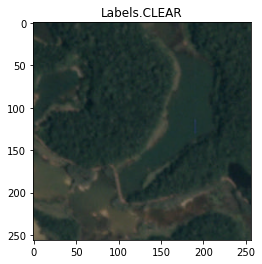

In [235]:
index = 21
plt.imshow(raw_dataset[0][index])
plt.title(Labels(raw_dataset[1][index]))
plt.show()

In [238]:
print(data[0])

[0.29114345 0.29204735 0.29267559]


In [244]:
rgb2hsv(raw_dataset[0][0][:, :, :3] / 255.0)

array([[[0.42222222, 0.13392857, 0.43921569],
        [0.40740741, 0.16071429, 0.43921569],
        [0.39814815, 0.16071429, 0.43921569],
        ...,
        [0.4       , 0.13392857, 0.43921569],
        [0.4047619 , 0.12612613, 0.43529412],
        [0.42857143, 0.12844037, 0.42745098]],

       [[0.42222222, 0.13761468, 0.42745098],
        [0.41176471, 0.1559633 , 0.42745098],
        [0.40740741, 0.16363636, 0.43137255],
        ...,
        [0.41111111, 0.13636364, 0.43137255],
        [0.42857143, 0.12844037, 0.42745098],
        [0.44047619, 0.12962963, 0.42352941]],

       [[0.4375    , 0.1509434 , 0.41568627],
        [0.43137255, 0.16037736, 0.41568627],
        [0.41666667, 0.16666667, 0.42352941],
        ...,
        [0.42857143, 0.13084112, 0.41960784],
        [0.44444444, 0.14018692, 0.41960784],
        [0.44791667, 0.14953271, 0.41960784]],

       ...,

       [[0.47222222, 0.16216216, 0.43529412],
        [0.46078431, 0.15315315, 0.43529412],
        [0.4537037 , 0